In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
FIG_REG_WIDTH = 7
FIG_REG_ASPECT_RATIO = 1.75

def set_fig_settings(fig_size=(32,10), font_size=16, font_scale=1.6):       
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams["legend.framealpha"] = 0

    font = {'weight' : 'normal', 'size'   : font_size}

    plt.rc('font', **font)

## Read Data

In [3]:
DATASET_PATH = 'data/uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_10k_train.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [4]:
for k in train_data:
    print("{}:\t{}".format(k, train_data[k].shape))

datetime:	(10000,)
land_cover:	(10000, 17, 30, 30)
latitude:	(10000,)
longitude:	(10000,)
meteorology:	(10000, 2, 5, 30, 30)
observed:	(10000, 5, 30, 30)
target:	(10000, 2, 30, 30)


## Data Viz

In [5]:
IDX = np.where(
    (np.sum(train_data['observed'][:,0],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,1],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,2],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,3],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,4],axis=(1,2)) > 50) & 
    (np.sum(train_data['target'][:,0],axis=(1,2)) > 50) 
)[0][0]

### Observed (T = 0, -12, -24, -36, -48 hours) -> (, 5, 30, 30)

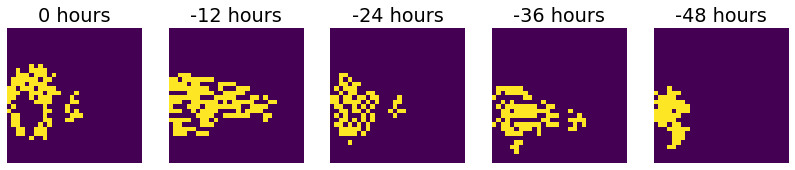

In [6]:
set_fig_settings((FIG_REG_WIDTH*2,FIG_REG_WIDTH*1.25))
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title(f'{-12 * (i)} hours')
    plt.imshow(train_data['observed'][IDX][i])
    plt.axis('off')

### LAT, LON float -> (, 1)

In [7]:
lat = train_data['latitude'][IDX]
lon = train_data['longitude'][IDX]
datetime = pd.to_datetime(train_data['datetime'][IDX])
print(f'Lat: {lat:.2f}, Lon: {lon:.2f}, Datetime: {datetime}')

Lat: 40.06, Lon: -121.24, Datetime: 2012-08-03 10:06:00


### Land Cover -> (, 17, 30, 30)

In [8]:
LAND_COVER_NAME_TO_IND = {'ASP': 0, 'CBD': 1, 'CBH': 2, 'CC': 3, 'CH': 4, 'DEM': 5,
                        'Nodata': 6, 'Sparse': 7, 'Tree': 8, 'Shrub': 9, 'Herb': 10, 'Water': 11, 'Barren': 12, 'Developed': 13, 'Snow-Ice': 14, 'Agriculture': 15,
                        'SLP': 16,}

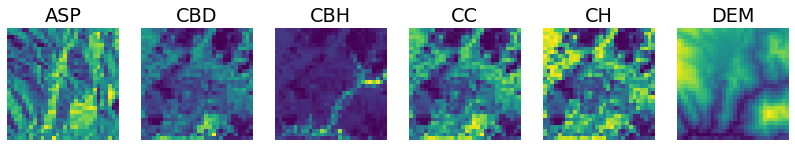

In [9]:
plt.figure()
for i, (layer_name, idx) in enumerate(list(LAND_COVER_NAME_TO_IND.items())[:6]):
    plt.subplot(1, 6, i+1)
    plt.imshow(train_data["land_cover"][IDX][idx])
    plt.title(layer_name)
    plt.axis('off')

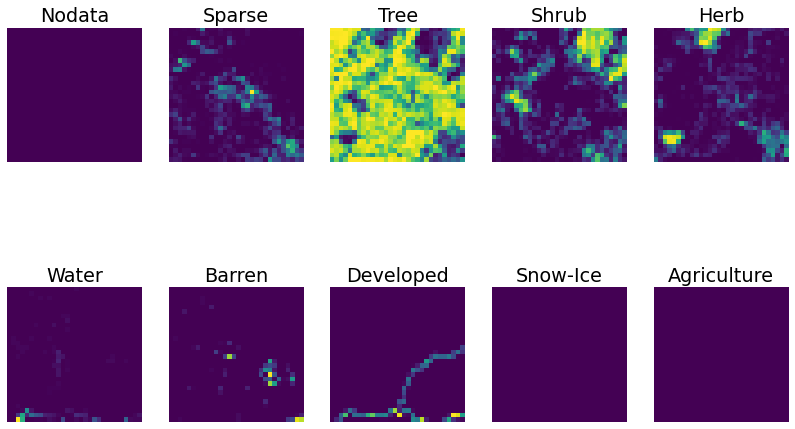

In [10]:
plt.figure()
for i, (layer_name, idx) in enumerate(list(LAND_COVER_NAME_TO_IND.items())[6:-1]):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data["land_cover"][IDX][idx])
    plt.title(layer_name)
    plt.axis('off')

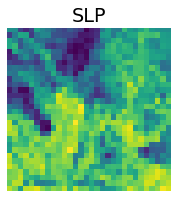

In [12]:
plt.figure(figsize = (3,3))
plt.imshow(train_data["land_cover"][IDX][16])
plt.axis("off")
plt.title("SLP")
plt.show()

## Meteorology -> (, 2, 5, 30, 30)

In [13]:
METEOROLOGY_NAME_TO_IND = {'Temp': 0, 'Rel. Humid.': 1, 'U Wind Comp.': 2, 'V Wind Comp.': 3, 'Precip. Rate': 4}

-48 hours


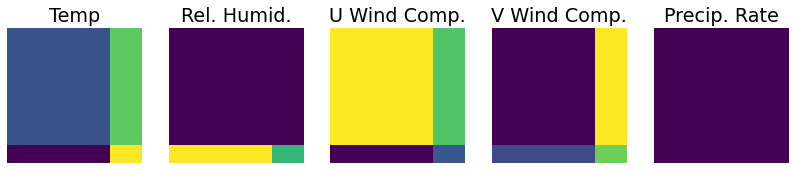

In [14]:
fig = plt.figure()
print("-48 hours")
for i, (name, idx) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data["meteorology"][IDX][0][idx])
    plt.title(name)
    plt.axis("off")

-36 hours


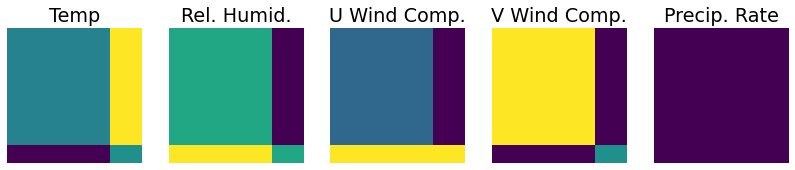

In [15]:
print("-36 hours")
for i, (name, idx) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data["meteorology"][IDX][1][idx])
    plt.title(name)
    plt.axis("off")

## Data Preparation

In [16]:
for k in train_data.keys():
    print("{}\t{}".format(k, np.isnan(train_data[k]).sum()))

datetime	0
land_cover	839580
latitude	0
longitude	0
meteorology	1622170
observed	0
target	0


In [17]:
def fill_missing_data_by_pixel(data_dict):
    print("Filling Missing Values By Pixel....\n")
    print("Land_COVER")
    for k, idx in LAND_COVER_NAME_TO_IND.items():
        old = np.isnan(data_dict["land_cover"][:, idx, ]).sum()
        if old != 0:
            for i in range(30):
                for j in range(30):
                    all_pixels = data_dict["land_cover"][:, idx, i, j]
                    data_dict["land_cover"][np.isnan(all_pixels), idx, i, j] = np.nanmean(all_pixels)
        new = np.isnan(data_dict["land_cover"][:, idx, ]).sum()
        print("{} Missing Values:\t{} -> {}".format(k, old, new))

    print()
    for time in range(2):
        for k, idx in METEOROLOGY_NAME_TO_IND.items():
            old = np.isnan(data_dict["meteorology"][:, time, idx, ]).sum()
            if old != 0:
                for i in range(30):
                    for j in range(30):
                        all_pixels = data_dict["meteorology"][:, time, idx, i, j]
                        data_dict["meteorology"][np.isnan(all_pixels), time, idx, i, j] = np.nanmean(all_pixels)
            new = np.isnan(data_dict["meteorology"][:, time, idx, ]).sum()
            print("{} Missing Values:\t{} -> {}".format(k, old, new))
    print()
    return data_dict

def concat_data(data_dict):
    print("\nConcatenating Data Dict...")
    data_master = np.concatenate((data_dict["observed"], data_dict["land_cover"], data_dict["meteorology"][:, 0], data_dict["meteorology"][:, 1]), axis = 1)
    print("Data Master Shape:  {}".format(data_master.shape))
    print()
    return data_master

def find_large_fire(data_dict, thres):
    large_fire_inds = np.where(
        (np.sum(data_dict['observed'][:,0],axis=(1,2)) > thres) & 
        (np.sum(data_dict['observed'][:,1],axis=(1,2)) > thres) & 
        (np.sum(data_dict['observed'][:,2],axis=(1,2)) > thres) & 
        (np.sum(data_dict['observed'][:,3],axis=(1,2)) > thres) & 
        (np.sum(data_dict['observed'][:,4],axis=(1,2)) > thres) & 
        (np.sum(data_dict['target'][:,0],axis=(1,2)) > thres) 
    )[0]
    return large_fire_inds


def prepare_X_y(data_dict, thres=3, target=0):
    print("Preparing X, y ...")
    fire_idx = find_large_fire(data_dict, thres)
    data_dict = fill_missing_data_by_pixel(data_dict)
    X_concat = concat_data(data_dict)
    X_fire = np.rollaxis(X_concat[fire_idx], 1, 4)
    assert(np.isnan(data_dict["target"][fire_idx, target, :, :]).sum() == 0)
    X, y = X_fire, data_dict["target"][fire_idx, target, :, :]
    print("X shape: {}    y shape: {}".format(X.shape, y.shape))
    return X, y

In [18]:
X_train, y_train = prepare_X_y(train_data)

Preparing X, y ...
Filling Missing Values By Pixel....

Land_COVER
ASP Missing Values:	119940 -> 0
CBD Missing Values:	119940 -> 0
CBH Missing Values:	119940 -> 0
CC Missing Values:	119940 -> 0
CH Missing Values:	119940 -> 0
DEM Missing Values:	119940 -> 0
Nodata Missing Values:	0 -> 0
Sparse Missing Values:	0 -> 0
Tree Missing Values:	0 -> 0
Shrub Missing Values:	0 -> 0
Herb Missing Values:	0 -> 0
Water Missing Values:	0 -> 0
Barren Missing Values:	0 -> 0
Developed Missing Values:	0 -> 0
Snow-Ice Missing Values:	0 -> 0
Agriculture Missing Values:	0 -> 0
SLP Missing Values:	119940 -> 0

Temp Missing Values:	125767 -> 0
Rel. Humid. Missing Values:	125767 -> 0
U Wind Comp. Missing Values:	125767 -> 0
V Wind Comp. Missing Values:	125767 -> 0
Precip. Rate Missing Values:	125767 -> 0
Temp Missing Values:	198667 -> 0
Rel. Humid. Missing Values:	198667 -> 0
U Wind Comp. Missing Values:	198667 -> 0
V Wind Comp. Missing Values:	198667 -> 0
Precip. Rate Missing Values:	198667 -> 0


Concatenatin

## Train CNN

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Dense, Reshape, Flatten, BatchNormalization

In [21]:
model = Sequential()
model.add(BatchNormalization(input_shape = (30, 30, 32)))
model.add(Conv2D(3, (3, 3), activation=tf.nn.relu))
model.add(Conv2D(3, (3, 3), activation=tf.nn.relu))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(900, activation="sigmoid"))
model.add(Reshape((30, 30)))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy', "Recall"])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 3)         867       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 3)         84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 507)               0         
_________________________________________________________________
dense (Dense)                (None, 900)               457200    
____

In [22]:
model.fit(X_train, y_train, batch_size=3, epochs=5, verbose=1, validation_split=0.2, shuffle=True)

Train on 4166 samples, validate on 1042 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
4166/4166 [==============================] - 14s 3ms/sample - loss: 0.1980 - acc: 0.9403 - recall: 0.0048 - val_loss: 0.1360 - val_acc: 0.9597 - val_recall: 0.0034
Epoch 2/5
4166/4166 [==============================] - 14s 3ms/sample - loss: 0.1663 - acc: 0.9409 - recall: 0.0406 - val_loss: 0.1319 - val_acc: 0.9580 - val_recall: 0.0398
Epoch 3/5
4166/4166 [==============================] - 14s 3ms/sample - loss: 0.1523 - acc: 0.9421 - recall: 0.1145 - val_loss: 0.1342 - val_acc: 0.9564 - val_recall: 0.0619
Epoch 4/5
4166/4166 [==============================] - 14s 3ms/sample - loss: 0.1426 - acc: 0.9441 - recall: 0.1817 - val_loss: 0.1384 - val_acc: 0.9554 - val_recall: 0.0754
Epoch 5/5
4166/4166 [==============================] - 14s 3ms/sample - loss: 0.1359 - acc: 0.9461 - recall: 0.2352 - val_loss: 0.1445 - val_acc: 0.9513 - val_rec

In [25]:
def check_model_results(idx, X, y, model = model):
    plt.subplot(1, 2, 1)
    plt.imshow(model.predict(X[idx,].reshape(-1, 30, 30, 32))[0])
    plt.title("prediction")
    plt.subplot(1, 2, 2)
    plt.imshow(y[idx,])
    plt.title("Actual")

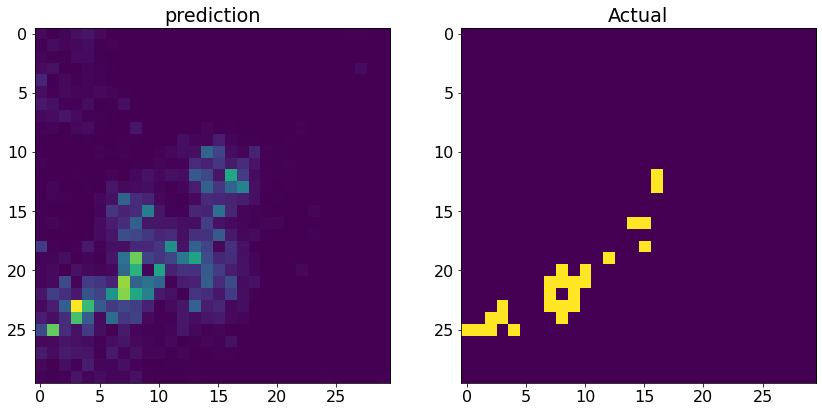

In [26]:
check_model_results(100, X_train, y_train)

## Testing

In [27]:
DATASET_PATH = 'data/uci_ml_hackathon_fire_dataset_2013-01-01_2014-01-01_5k_test.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    test_data = {}
    for k in list(f):
        test_data[k] = f[k][:]

In [28]:
X_test, y_test = prepare_X_y(test_data)

Preparing X, y ...
Filling Missing Values By Pixel....

Land_COVER
ASP Missing Values:	6362 -> 0
CBD Missing Values:	6362 -> 0
CBH Missing Values:	6362 -> 0
CC Missing Values:	6362 -> 0
CH Missing Values:	6362 -> 0
DEM Missing Values:	6362 -> 0
Nodata Missing Values:	0 -> 0
Sparse Missing Values:	0 -> 0
Tree Missing Values:	0 -> 0
Shrub Missing Values:	0 -> 0
Herb Missing Values:	0 -> 0
Water Missing Values:	0 -> 0
Barren Missing Values:	0 -> 0
Developed Missing Values:	0 -> 0
Snow-Ice Missing Values:	0 -> 0
Agriculture Missing Values:	0 -> 0
SLP Missing Values:	6362 -> 0

Temp Missing Values:	126 -> 0
Rel. Humid. Missing Values:	126 -> 0
U Wind Comp. Missing Values:	126 -> 0
V Wind Comp. Missing Values:	126 -> 0
Precip. Rate Missing Values:	126 -> 0
Temp Missing Values:	126 -> 0
Rel. Humid. Missing Values:	126 -> 0
U Wind Comp. Missing Values:	126 -> 0
V Wind Comp. Missing Values:	126 -> 0
Precip. Rate Missing Values:	126 -> 0


Concatenating Data Dict...
Data Master Shape:  (5000, 32

In [29]:
model.evaluate(X_test, y_test)

2510/2510 [==============================] - 1s 343us/sample - loss: 0.2280 - acc: 0.9294 - recall: 0.0855


[0.22799792622783743, 0.92938715, 0.08553819]

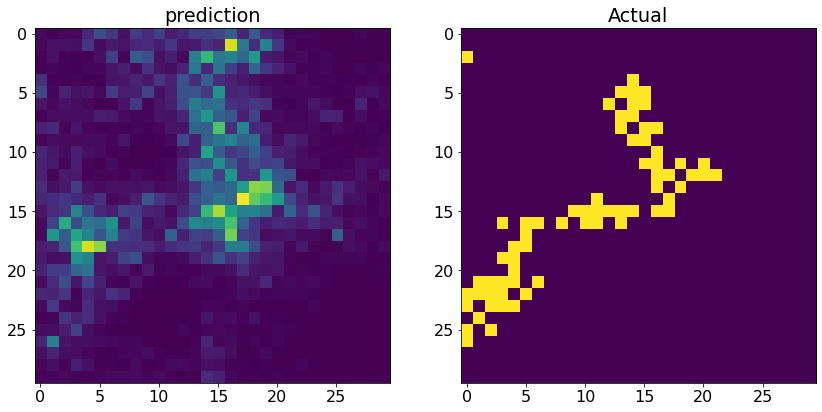

In [30]:
check_model_results(100, X_test, y_test)

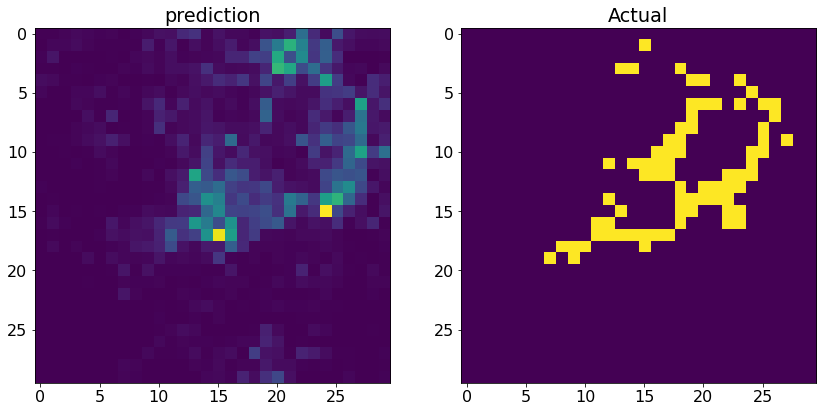

In [32]:
check_model_results(1000, X_test, y_test)